In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [4]:
import sys
sys.path.append('..')

from src.visualization import plot_bar_chart, plot_dist, plot_boxplot, plot_multi_boxplot,histogram_and_density,box_plot_numeric, plot_Lift_curve
from src.utils import label, print_stats

# EDA

Bộ dữ liệu HMEQ bao gồm các đặc trưng thông tin nợ quá hạn của 5960 khoản vay mua nhà. Đây là những khoản vay mà người vay sử dụng vốn chủ sở hữu làm tài sản thế chấp cơ sở. Tập dữ liệu bao gồm những trường sau:

- BAD: 1 = Hồ sơ vay là vi phạm hoặc mất khả năng trả nợ; 0 = hồ sơ vay đã và đang trả nợ.
- LOAN: Số tiền yêu cầu cho vay.
- MORTDUE: Số tiền đến hạn của khoản thế chấp hiện có.
- VALUE: Giá trị tài sản hiện tại.
- REASON: DebtCon = nợ hợp nhất; HomeImp = cải thiện nhà.
- JOB: Thể loại nghề nghiệp.
- YOJ: Số năm kinh nghiệm trong nghề nghiệp hiện tại.
- DEROG: Số lượng báo cáo không tín nhiệm.
- DELINQ: Số hạn mức tín dụng quá hạn.
- CLAGE: Tuổi của hạn mức tín dụng cũ nhất tính theo tháng.
- NINQ: Số câu hỏi tín dụng gần đây.
- CLNO: Số lượng hạn mức tín dụng.
- DEBTINC: Tỷ lệ nợ trên thu nhập.

In [5]:
# Load data 
data = pd.read_csv("hmeq.csv")

In [6]:
data

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [7]:
# Descriptive analysis
data.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [8]:
#Missing value
missing_data = pd.DataFrame({"Missing value": data.isnull().sum()})
missing_data.reset_index()

,index,Missing value
0,BAD,0
1,LOAN,0
2,MORTDUE,518
3,VALUE,112
4,REASON,252
5,JOB,279
6,YOJ,515
7,DEROG,708
8,DELINQ,580
9,CLAGE,308


In [9]:
label_bad = {0: 'no', 1: 'yes'}
data['bad_label'] = data['BAD'].map(label_bad)

In [10]:
data.head(5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,bad_label
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN,yes
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN,yes
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN,yes
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN,no


### Observe relationship between BAD and REASON

In [11]:
data['REASON'] = data['REASON'].fillna('Missing')
data['JOB'] = data['JOB'].fillna('Missing')

In [12]:
bad_by_reason = data.groupby(['REASON','bad_label']).size().unstack(fill_value=0).reset_index()
bad_by_reason['total']=bad_by_reason["no"]+bad_by_reason["yes"]
bad_by_reason['bad_rate']=bad_by_reason["yes"]/bad_by_reason['total']*100
bad_by_reason.sort_values(by="no", ascending = False, inplace = True)
bad_by_reason.head(5)

bad_label,REASON,no,yes,total,bad_rate
0,DebtCon,3183,745,3928,18.966395
1,HomeImp,1384,396,1780,22.247191
2,Missing,204,48,252,19.047619


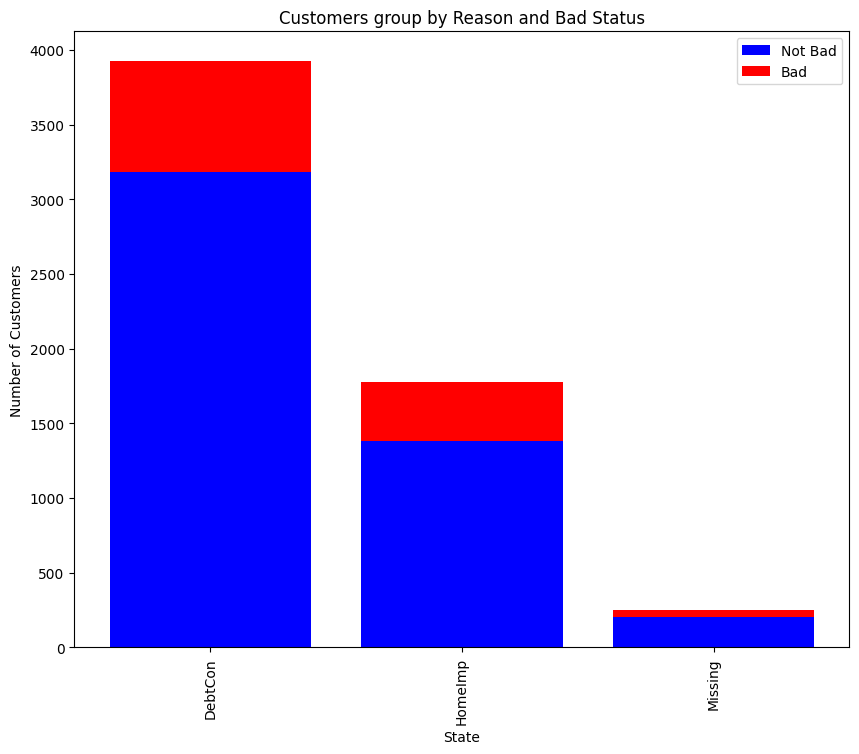

In [13]:
x= bad_by_reason.REASON
y1= bad_by_reason.no
y2= bad_by_reason.yes


plt.figure(figsize=(10,8))
plt.bar(x, y1, color='b')
plt.bar(x, y2, bottom=y1, color='r')
plt.xlabel("State")
plt.xticks(rotation='vertical')
plt.ylabel("Number of Customers")
plt.legend(['Not Bad',  'Bad'])
plt.title("Customers group by Reason and Bad Status")
plt.show()

### Observe relationship between BAD and JOB

In [14]:
bad_by_job = data.groupby(['JOB','bad_label']).size().unstack(fill_value=0).reset_index()
bad_by_job['total']=bad_by_job["no"]+bad_by_job["yes"]
bad_by_job['bad_rate']=bad_by_job["yes"]/bad_by_job['total']*100
bad_by_job.sort_values(by="no", ascending = False, inplace = True)
bad_by_job.head(5)

bad_label,JOB,no,yes,total,bad_rate
3,Other,1834,554,2388,23.199330
4,ProfExe,1064,212,1276,16.614420
2,Office,823,125,948,13.185654
0,Mgr,588,179,767,23.337679
1,Missing,256,23,279,8.243728


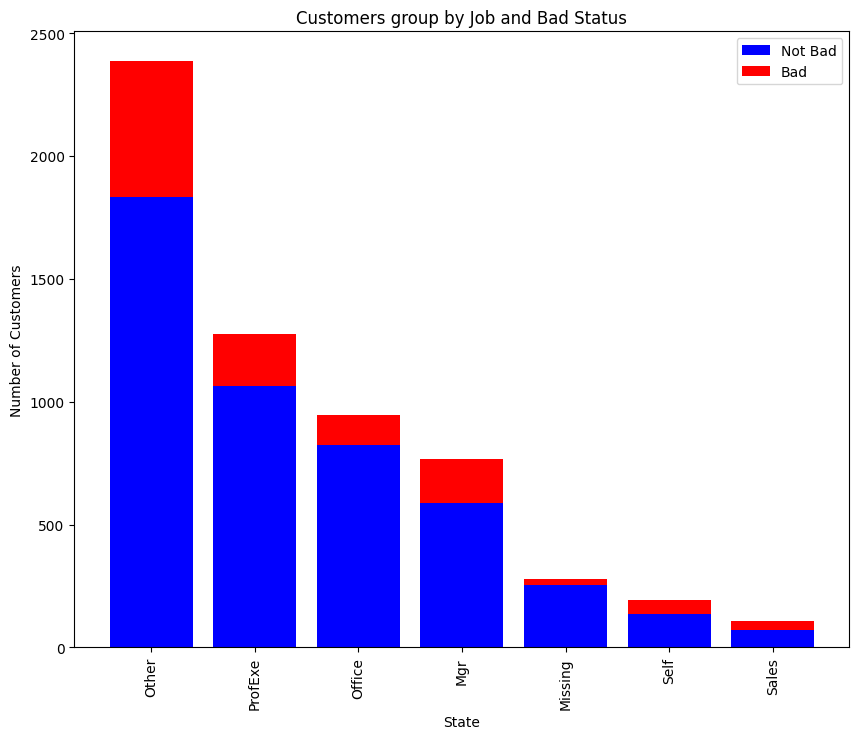

In [15]:
x= bad_by_job.JOB
y1= bad_by_job.no
y2= bad_by_job.yes


plt.figure(figsize=(10,8))
plt.bar(x, y1, color='b')
plt.bar(x, y2, bottom=y1, color='r')
plt.xlabel("State")
plt.xticks(rotation='vertical')
plt.ylabel("Number of Customers")
plt.legend(['Not Bad',  'Bad'])
plt.title("Customers group by Job and Bad Status")
plt.show()

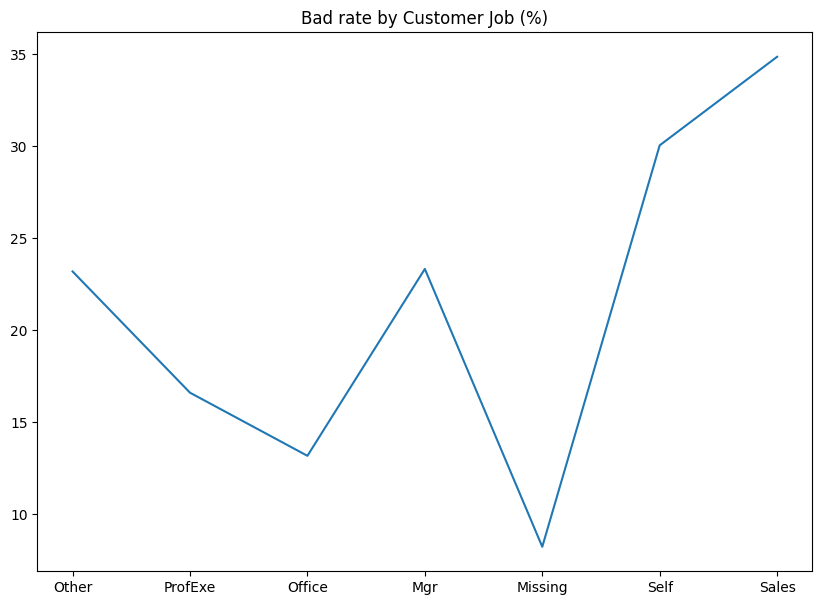

In [16]:
plt.figure(figsize=(10,7))
plt.plot(bad_by_job.JOB, bad_by_job.bad_rate)
plt.title("Bad rate by Customer Job (%)")
plt.show()# Plot the chart

### Observe relationship between BAD and continuous variables

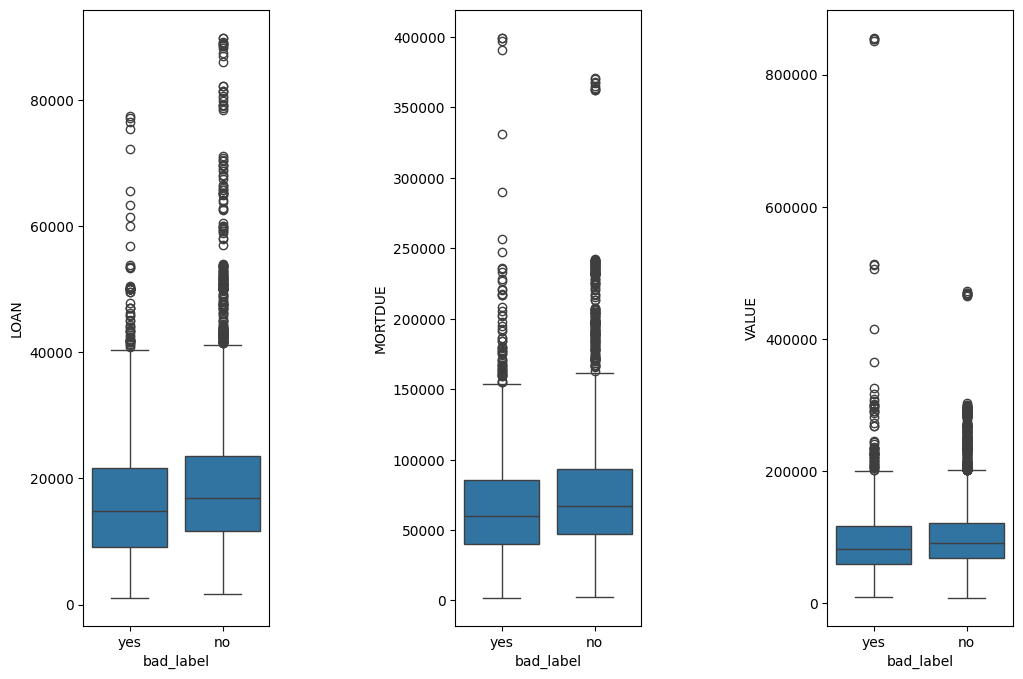

In [17]:
# Box plot
box_plot_numeric(df = data, columns = ['LOAN', 'MORTDUE', 'VALUE'], target = 'bad_label')

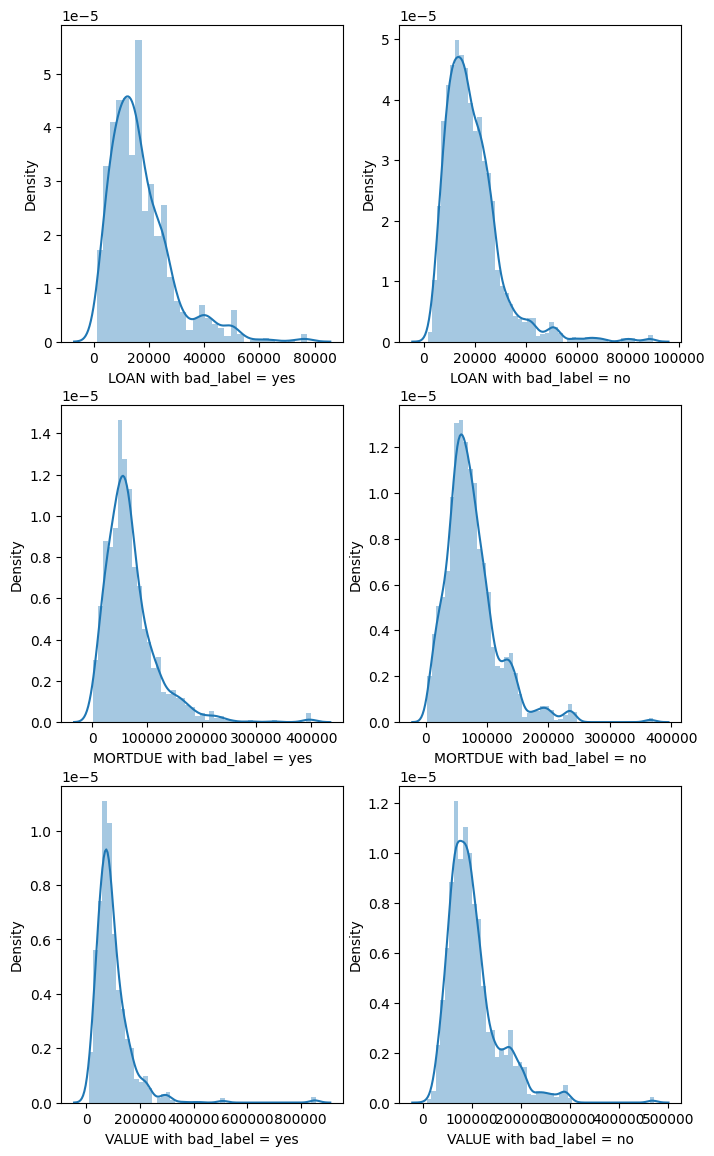

In [18]:
histogram_and_density(df = data, columns = ['LOAN', 'MORTDUE', 'VALUE'], target = 'bad_label')

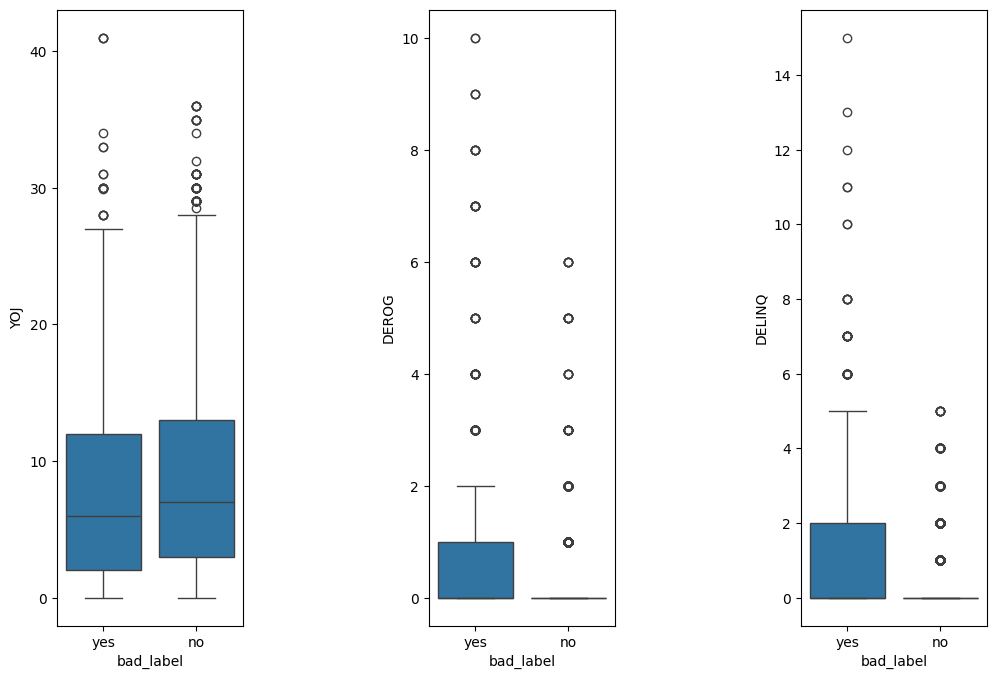

In [19]:
box_plot_numeric(df = data, columns = ['YOJ', 'DEROG','DELINQ'], target = 'bad_label')

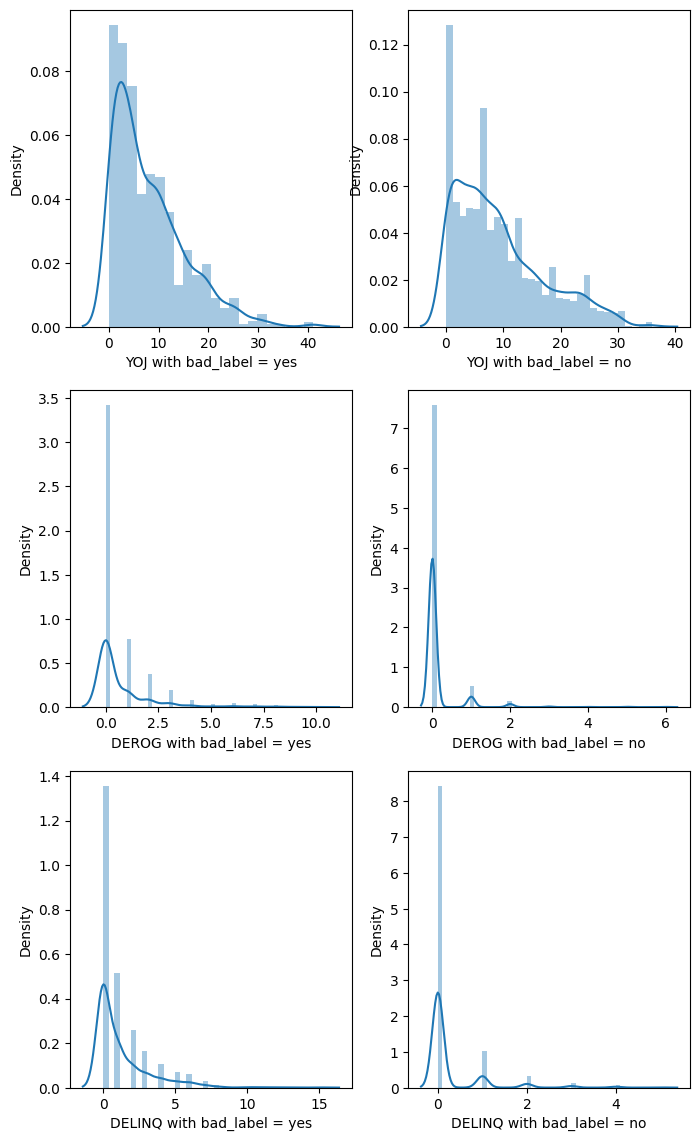

In [20]:
histogram_and_density(df = data, columns = ['YOJ', 'DEROG','DELINQ'], target = 'bad_label')

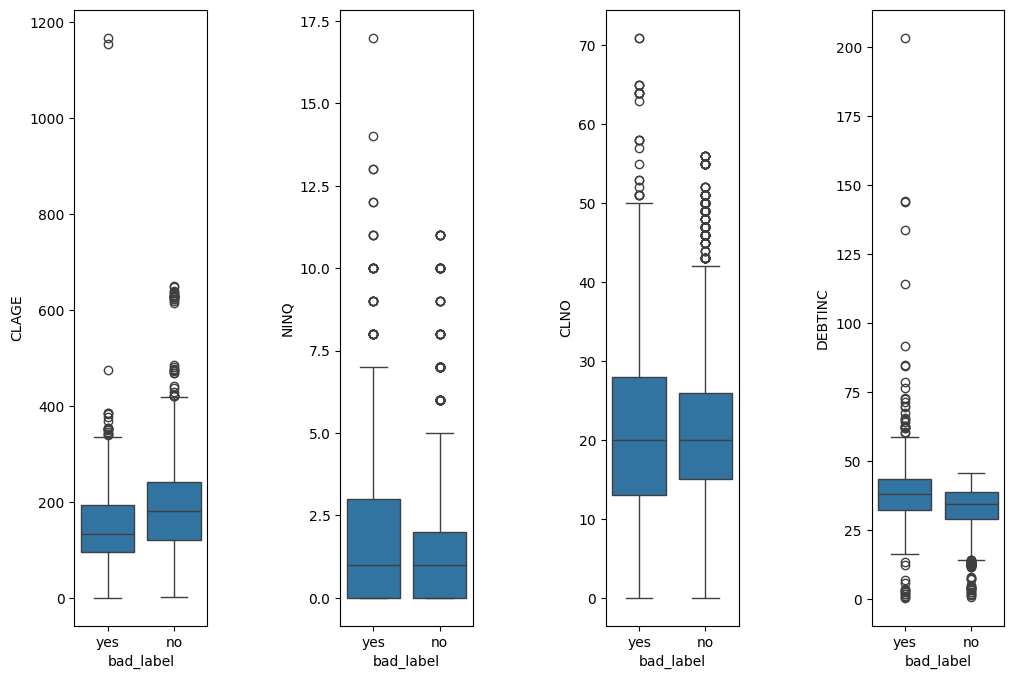

In [21]:
box_plot_numeric(df = data, columns = ['CLAGE', 'NINQ', 'CLNO', 'DEBTINC'], target = 'bad_label')

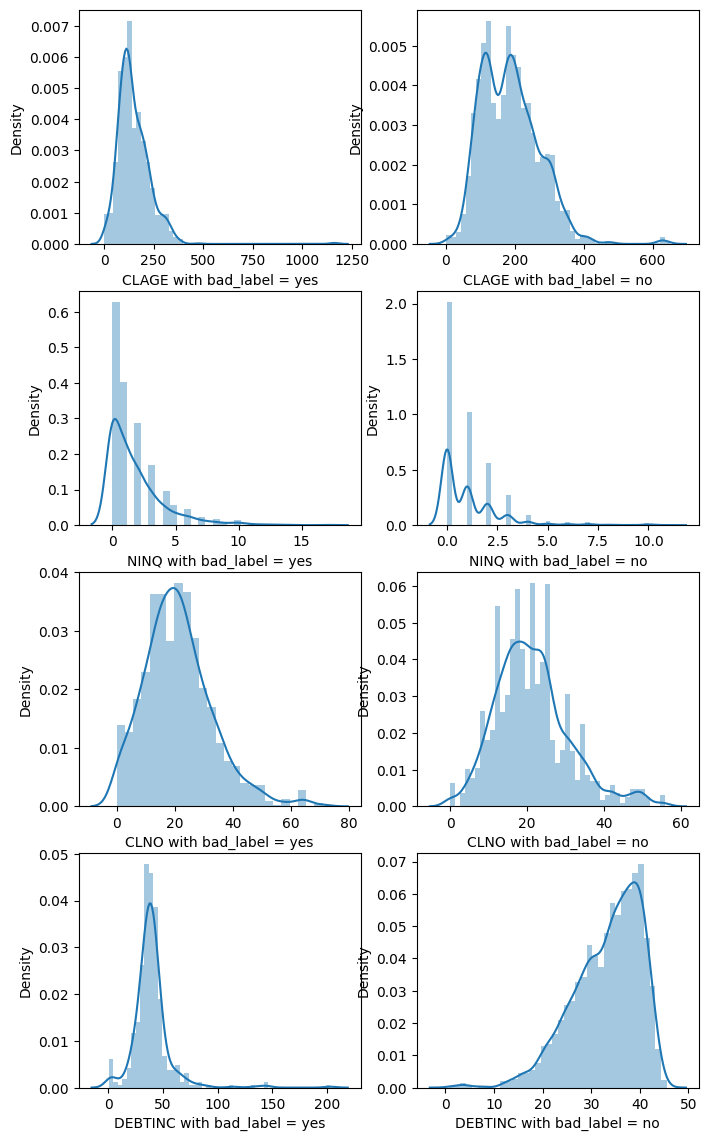

In [22]:
histogram_and_density(df = data, columns = ['CLAGE', 'NINQ', 'CLNO', 'DEBTINC'], target = 'bad_label')

# Feature Engineering

In [23]:
df=data.drop("bad_label", axis=1)

In [24]:
def _bin_table(data, col_name, n_bins=10):
    df1 = data.loc[:, [col_name, 'BAD']]
    if df1[col_name].dtypes != 'object':
        bins, threshold = pd.qcut(df1[col_name], q=n_bins, retbins=True, duplicates='drop')
        threshold[0] = -np.inf
        threshold[-1] = np.inf
        bins, threshold = pd.cut(df1[col_name], bins=threshold, retbins=True)
        df1[col_name] = bins
    elif df1[col_name].dtypes == 'object':
        threshold = df1[col_name].unique()
    pivoted = df1.pivot_table(index=col_name, columns='BAD', aggfunc={'BAD': 'count'})
    pivoted = pivoted['BAD'].rename(columns={0: 'GOOD', 1: 'BAD'})
    pivoted.columns.name = None
    pivoted.index.name = col_name
    pivoted['Obs'] = pivoted['GOOD'] + pivoted['BAD']
    pivoted['GOOD/BAD'] = pivoted['GOOD']/pivoted['BAD']
    pivoted['%BAD'] = pivoted['BAD']/pivoted['BAD'].sum()
    pivoted['%GOOD'] = pivoted['GOOD']/pivoted['GOOD'].sum()
    pivoted['WoE'] = np.log(pivoted['%GOOD']/pivoted['%BAD']) 
    pivoted['BAD'].fillna(0, inplace=True)
    pivoted['GOOD'].fillna(0, inplace=True)
    #pivoted['AdjustedWOE'] = np.log(((pivoted['GOOD'] + 0.5) /pivoted['GOOD'].sum()) / ((pivoted['BAD'] + 0.5) / pivoted['BAD'].sum()))
    #pivoted['WoE'].fillna(pivoted['AdjustedWOE'], inplace=True)
    pivoted['IV'] = (pivoted['%GOOD'] - pivoted['%BAD'])*pivoted['WoE']
    pivoted['IV_value'] = pivoted['IV'].sum()
    pivoted['Variable'] = col_name
    #pivoted=pivoted.sort_values("WoE", ascending=True)
    return pivoted

In [25]:
JOB=_bin_table(df, "JOB")

In [26]:
JOB

,GOOD,BAD,Obs,GOOD/BAD,%BAD,%GOOD,WoE,IV,IV_value,Variable
JOB,,,,,,,,,,
Mgr,588,179,767,3.284916,0.150547,0.123245,-0.200102,0.005463,0.123731,JOB
Missing,256,23,279,11.130435,0.019344,0.053658,1.020240,0.035008,0.123731,JOB
Office,823,125,948,6.584000,0.105130,0.172501,0.495199,0.033362,0.123731,JOB
Other,1834,554,2388,3.310469,0.465938,0.384406,-0.192353,0.015683,0.123731,JOB
ProfExe,1064,212,1276,5.018868,0.178301,0.223014,0.223761,0.010005,0.123731,JOB
Sales,71,38,109,1.868421,0.031960,0.014882,-0.764350,0.013054,0.123731,JOB
Self,135,58,193,2.327586,0.048780,0.028296,-0.544612,0.011156,0.123731,JOB


In [27]:
loan=_bin_table(df, "LOAN")

In [28]:
loan

,GOOD,BAD,Obs,GOOD/BAD,%BAD,%GOOD,WoE,IV,IV_value,Variable
LOAN,,,,,,,,,,
"(-inf, 7600.0]",374,229,603,1.633188,0.192599,0.078390,-0.898910,0.102663,0.160156,LOAN
"(7600.0, 10000.0]",471,137,608,3.437956,0.115223,0.098721,-0.154566,0.002551,0.160156,LOAN
"(10000.0, 12100.0]",476,106,582,4.490566,0.089151,0.099769,0.112535,0.001195,0.160156,LOAN
"(12100.0, 14400.0]",503,107,610,4.700935,0.089992,0.105429,0.158318,0.002444,0.160156,LOAN
"(14400.0, 16300.0]",447,131,578,3.412214,0.110177,0.093691,-0.162082,0.002672,0.160156,LOAN
"(16300.0, 18800.0]",520,84,604,6.190476,0.070648,0.108992,0.433569,0.016625,0.160156,LOAN
"(18800.0, 21700.0]",492,99,591,4.969697,0.083263,0.103123,0.213916,0.004248,0.160156,LOAN
"(21700.0, 25000.0]",506,107,613,4.728972,0.089992,0.106057,0.164265,0.002639,0.160156,LOAN
"(25000.0, 30500.0]",504,72,576,7.000000,0.060555,0.105638,0.556467,0.025087,0.160156,LOAN


In [29]:
data_feature=df.drop("BAD", axis=1)

In [30]:
result = pd.DataFrame()
for col_name in data_feature.columns:
    try:
        result1 = _bin_table(df, col_name)
        result1.reset_index(inplace = True)
        print(result1)
        result = result2.append(result)
    except Exception as e:
        print(e)

                 LOAN  GOOD  BAD  Obs  GOOD/BAD      %BAD     %GOOD       WoE  \
0      (-inf, 7600.0]   374  229  603  1.633188  0.192599  0.078390 -0.898910   
1   (7600.0, 10000.0]   471  137  608  3.437956  0.115223  0.098721 -0.154566   
2  (10000.0, 12100.0]   476  106  582  4.490566  0.089151  0.099769  0.112535   
3  (12100.0, 14400.0]   503  107  610  4.700935  0.089992  0.105429  0.158318   
4  (14400.0, 16300.0]   447  131  578  3.412214  0.110177  0.093691 -0.162082   
5  (16300.0, 18800.0]   520   84  604  6.190476  0.070648  0.108992  0.433569   
6  (18800.0, 21700.0]   492   99  591  4.969697  0.083263  0.103123  0.213916   
7  (21700.0, 25000.0]   506  107  613  4.728972  0.089992  0.106057  0.164265   
8  (25000.0, 30500.0]   504   72  576  7.000000  0.060555  0.105638  0.556467   
9      (30500.0, inf]   478  117  595  4.085470  0.098402  0.100189  0.017993   

         IV  IV_value Variable  
0  0.102663  0.160156     LOAN  
1  0.002551  0.160156     LOAN  
2  0.0011

In [31]:
df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

### Correlation

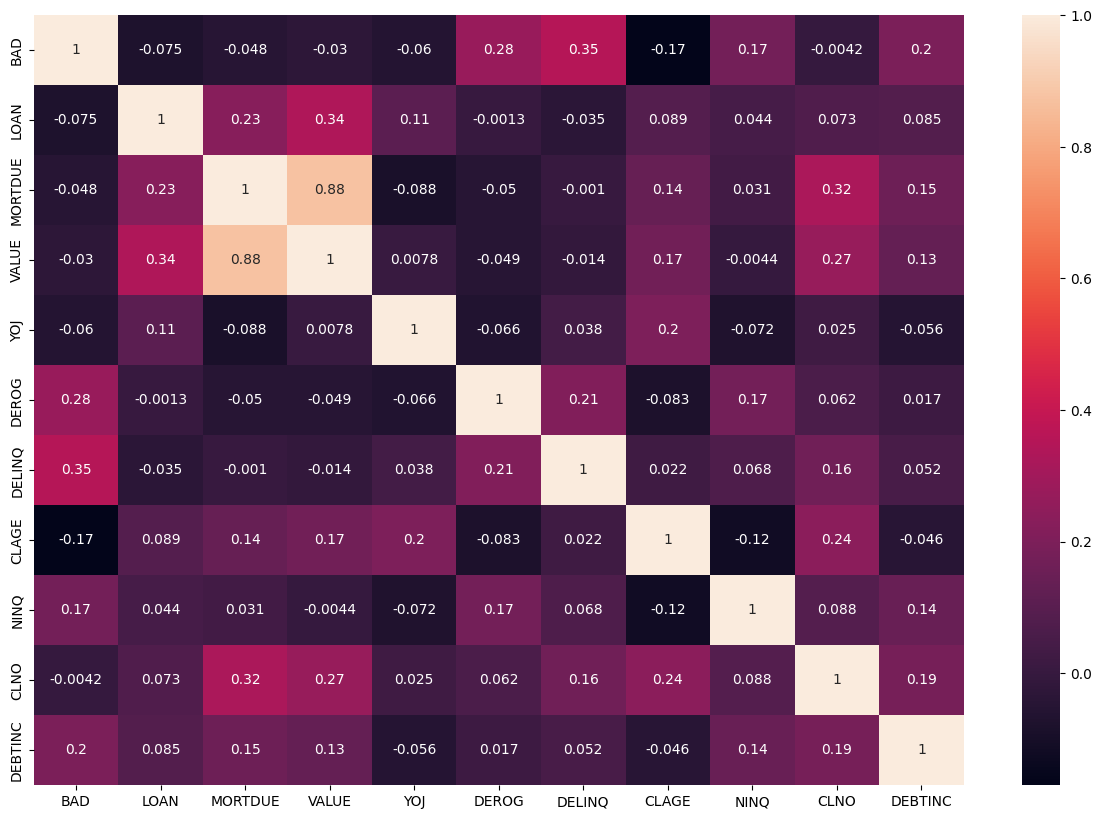

In [32]:
numerics = ['int64', 'float64'] # continuous variable
train_numerics = data.select_dtypes(include=numerics)
corr_matrix = train_numerics.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

### Collinearity

In [33]:
X_variables = data.select_dtypes(include=numerics).drop(["BAD"], axis = 1)
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data.sort_values(by = 'VIF', ascending = False, inplace= True)

MissingDataError: exog contains inf or nans